In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import seaborn as sns
sns.set_context("talk")
import cv2
import os
import glob
import json

rim_paths = {
    "coffee": "/home/marc/git/scratch/Supermarkt/enrichment_csv/Supermarket_Demo_2021_REFERENCE-IMAGE-MAPPER_Coffee_-_long_scanning_csv",
    "cereal": "/home/marc/git/scratch/Supermarkt/enrichment_csv/Supermarket_Demo_2021_REFERENCE-IMAGE-MAPPER_Cereal_-_long_scanning_csv",
    "shampoo": "/home/marc/git/scratch/Supermarkt/enrichment_csv/Supermarket_Demo_2021_REFERENCE-IMAGE-MAPPER_Shampoo_-_long_scanning_csv",    
    "detergent": "/home/marc/git/scratch/Supermarkt/enrichment_csv/Supermarket_Demo_2021_REFERENCE-IMAGE-MAPPER_Detergent_1_-_long_scanning_csv",    
}

In [2]:
gaze = {k: pd.read_csv(os.path.join(v, "gaze.csv")) for k, v in rim_paths.items()}
for k, df in gaze.items():
    df["shelf"] = k
    gaze[k] = df

gaze = pd.concat(gaze.values())
gaze.head()

,section id,recording id,timestamp [ns],gaze detected in reference image,gaze position in reference image x [pixel],gaze position in reference image y [pixel],shelf
0,4029c324-584d-4589-b0e8-da3edac4bd0f,02da87d3-d27a-4eee-92b6-4d44c22c362f,1614328230204761483,False,NaN,NaN,coffee
1,4029c324-584d-4589-b0e8-da3edac4bd0f,02da87d3-d27a-4eee-92b6-4d44c22c362f,1614328230208849483,False,NaN,NaN,coffee
2,4029c324-584d-4589-b0e8-da3edac4bd0f,02da87d3-d27a-4eee-92b6-4d44c22c362f,1614328230212734483,False,NaN,NaN,coffee
3,4029c324-584d-4589-b0e8-da3edac4bd0f,02da87d3-d27a-4eee-92b6-4d44c22c362f,1614328230220853483,False,NaN,NaN,coffee
4,4029c324-584d-4589-b0e8-da3edac4bd0f,02da87d3-d27a-4eee-92b6-4d44c22c362f,1614328230224885483,False,NaN,NaN,coffee


## Dwell Time

Text(0, 0.5, 'Gaze Samples')

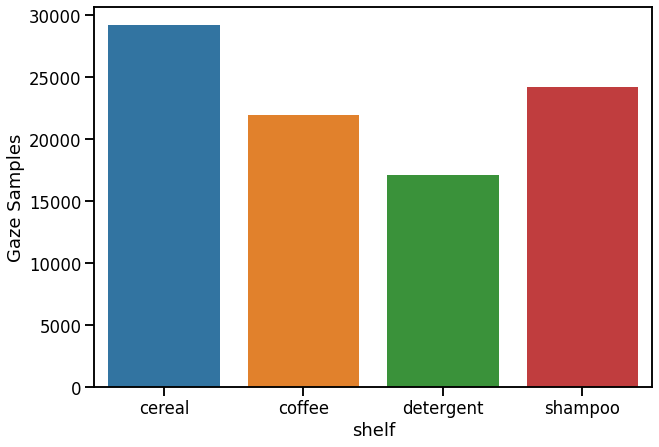

In [3]:
res = gaze.groupby("shelf")["gaze detected in reference image"].sum()

plt.figure(figsize=(10,7))
sns.barplot(x=res.index, y=res)

plt.ylabel("Gaze Samples")

## Time to first Contact

**Issue:** it is hard to access recording and wearer meta-data belonging to an enrichment section. Even with an existing raw data exporter enrichment this remains difficult. Raw data exporter contains the meta data, but is also independently sectioned. It comes down to broot-force parsing all existing sections for the recording ID.

In [4]:
raw_path = "/home/marc/git/scratch/Supermarkt/raw_data_exporter/"

start_times = {}
for filepath in glob.iglob(raw_path + "*/info.json", recursive=True):
    with open(filepath) as f:
        data = json.load(f)
    start_times[data["recording_id"]] = data["start_time"]

In [5]:
gaze_times = gaze.copy()

def offset_start(row):
    row["timestamp [ns]"] -= start_times[row["recording id"]]
    return row
gaze_times = gaze_times.apply(offset_start, axis=1)

Text(0.5, 1.0, 'Time to first Contact')

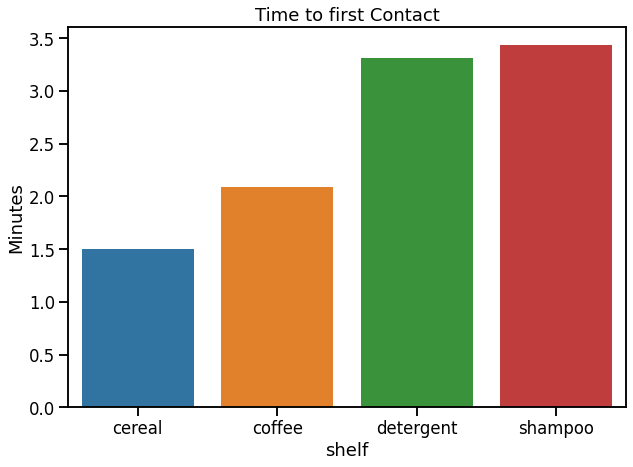

In [6]:
df = gaze_times.copy()
df = df[df["gaze detected in reference image"]]
res = df.groupby(["shelf", "recording id"]).first().reset_index().groupby("shelf")["timestamp [ns]"].mean() / 1e9 / 60

plt.figure(figsize=(10,7))
sns.barplot(x=res.index, y=res)
plt.ylabel("Minutes")
plt.title("Time to first Contact")

## Spatial Journey

Text(0.5, 1.0, 'Spatial Journey')

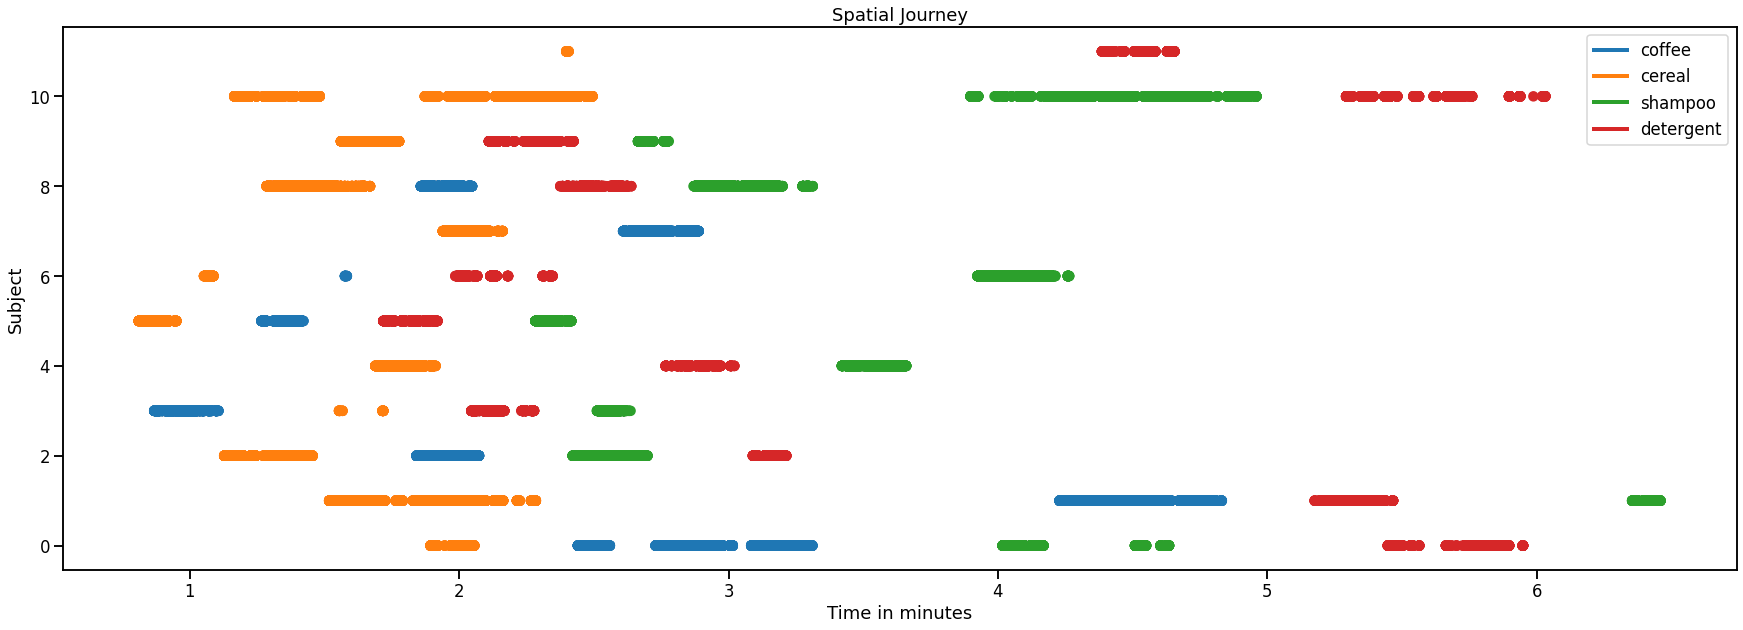

In [7]:
plt.figure(figsize=(30,10))

color_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_map = {key: color_palette[idx] for idx, key in enumerate(gaze_times["shelf"].unique())}

for idx, rec_id in enumerate(gaze_times["recording id"].unique()):
    df = gaze_times[gaze_times["recording id"] == rec_id]
    df = df[df["gaze detected in reference image"]]
    
    colors = df["shelf"].map(color_map)
    ts = df["timestamp [ns]"] / 1e9 / 60
    plt.scatter(ts , idx * np.ones_like(ts), c=colors)

plt.xlabel("Time in minutes")
plt.ylabel("Subject")


custom_lines = [mpl.lines.Line2D([0], [0], color=c, lw=4) for c in color_map.values()]
plt.legend(custom_lines, color_map.keys())

plt.title("Spatial Journey")

Text(0.5, 1.0, 'Spatial Journey normalized by Subjects Trial Time')

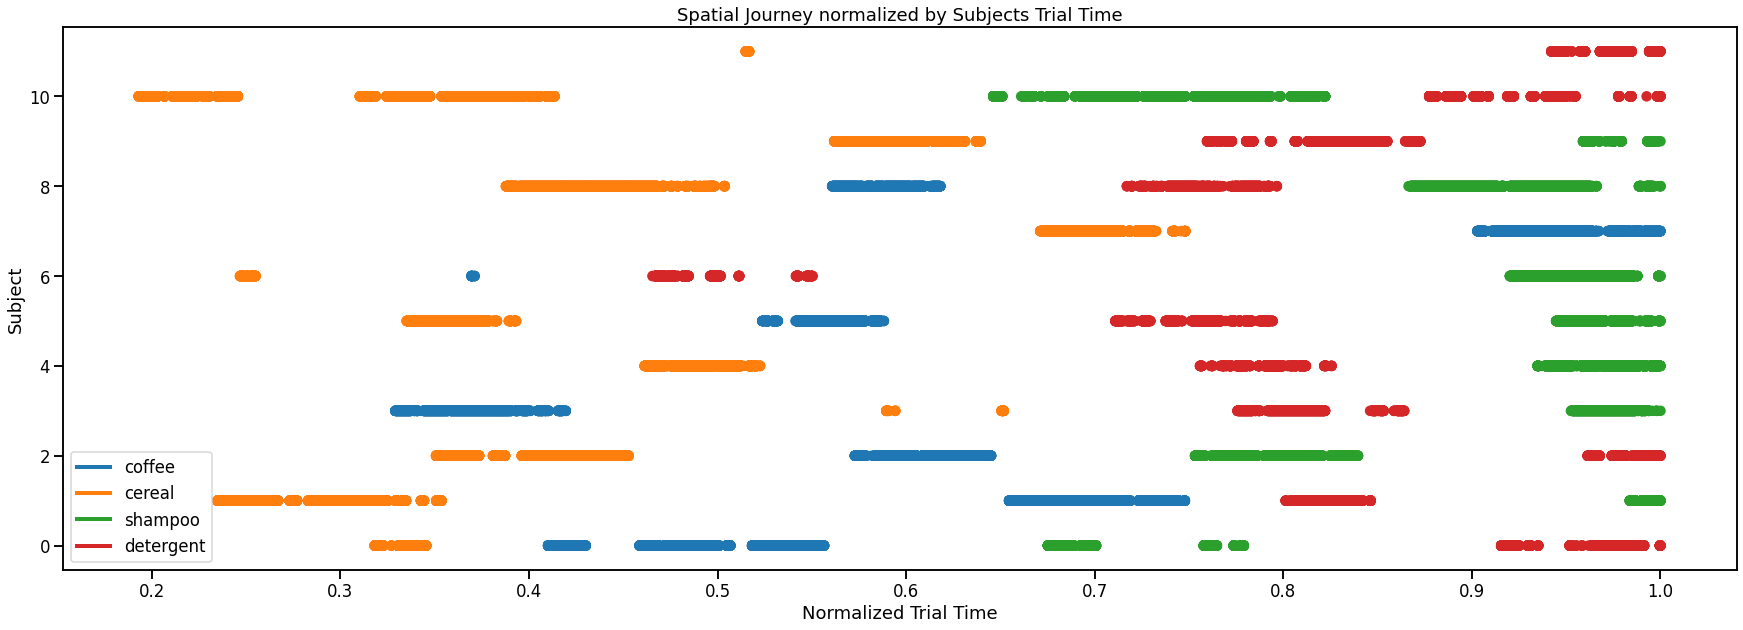

In [8]:
plt.figure(figsize=(30,10))

color_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_map = {key: color_palette[idx] for idx, key in enumerate(gaze_times["shelf"].unique())}

for idx, rec_id in enumerate(gaze_times["recording id"].unique()):
    df = gaze_times[gaze_times["recording id"] == rec_id]
    df = df[df["gaze detected in reference image"]]
    
    colors = df["shelf"].map(color_map)
    ts = df["timestamp [ns]"] / df["timestamp [ns]"].max()
    plt.scatter(ts , idx * np.ones_like(ts), c=colors)

plt.xlabel("Normalized Trial Time")
plt.ylabel("Subject")


custom_lines = [mpl.lines.Line2D([0], [0], color=c, lw=4) for c in color_map.values()]
plt.legend(custom_lines, color_map.keys())

plt.title("Spatial Journey normalized by Subjects Trial Time")